# Analysis and Prediction of Flight Delays

Flight delays are often due to weather, ATC limitations, or airline causes such as crew availability or mechanical issues. While measuring each of these causes directly may prove challenging, certain components of a typical flight may indirectly reveal, through common patterns, these issues. For example, departure times in the mid-afternoon are more likely to encounter weather delays in the summer due to the frequency of afternoon thunderstorms, certain airlines or aircraft are more likely to experience mechanical or crew availability issues, and evening flights are more likely to experience delays due to late inbound aircraft from delays caused earlier in the day. This notebook demonstrates these simple correlations and then provides a trained machine learning model to predict flight delays with reasonable accuracy.

## Airline Delay Data

The core data used for this analysis comes from the [Airline Delay Analysis](https://www.kaggle.com/datasets/sherrytp/airline-delay-analysis?resource=download) dataset available on Kaggle. Data hase been selected for 2019, with the primary CSV containing over 10 million rows of data.

The data will be imported as a dataframe, and the following transformations will be applied:
- The 'FL_DATE' column, representing the flight date, will be transformed to simply contain the month of the year. This should effectively capture seasonal fluctuations in flight delay patterns.
- The 'DEP_TIME' column, representing the departure time of each flight, will be transformed to consist only of the hour of the day. This should capture delay patterns based on operational patterns throughout the day.
- The 'ARR_DELAY' column, which represents the arrival delay of the flight, represents the target variable and will be transformed to the following categories:
    - 'NO_DELAY' - represents arrival delays of 15 minutes or less, which most airlines consider an 'on-time' arrival
    - 'MINOR_DELAY' - represents delays between 15 and 45 minutes, which are not likely to cause any significant disruptions
    - 'MAJOR_DELAY' - represents delays beyond 45 minutes and up to 2 hours, which may cause serious disruptions in passenger movement
    - 'SEVERE_DELAY' - represents delays beyond 2 hours which are guaranteed to cause significant disruptions and costs in passenger movement
- The 'OP_UNIQUE_CARRIER' column, which represents the airline carrier, will be included and preprocessed as a categorical feature - and represents that certain carriers are more likely to experience delays
- The 'ORIGIN' and 'DESTINATION' columns, which represent the airports the flight is operating to and from, will also be included as categorical features and should capture variations based on the flight's location 

In [3]:
import pandas as pd

df = pd.read_csv('data/2019.csv')

# Remove any rows where this data is missing
df = df.dropna(subset=['FL_DATE', 'DEP_TIME', 'ARR_DELAY'])

# Transform from format 2019-11-17 -> 11
df['FL_MONTH'] = df['FL_DATE'].apply(lambda x: int(x[5:7]))

# Transform from format 1715 (converted to 1715.0 by pd) -> 17
df['DEP_HOUR'] = df['DEP_TIME'].apply(lambda x: int(x // 100))

def categorize_delay(delay):
    if delay < 15:
        return 'NO_DELAY'
    elif delay < 45:
        return 'MINOR_DELAY'
    elif delay < 120:
        return 'MAJOR_DELAY'
    else:
        return 'SEVERE_DELAY'

# Transform into categories for making categorical predictions
df['DELAY_CATEGORY'] = df['ARR_DELAY'].apply(categorize_delay)

# Drop the remaining unused columns
keep_columns = ['FL_MONTH', 'DEP_HOUR', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DELAY_CATEGORY']
df = df[keep_columns]

## Sampling

To make the data easier to work with, it should be sampled down to a reasonable number.

In [4]:
import ipywidgets as widgets
from IPython.display import display

sample_slider = widgets.IntSlider(value=50000, min=1000, max=1000000, step=1000, description='Sample Size:')
display(sample_slider)

IntSlider(value=50000, description='Sample Size:', max=1000000, min=1000, step=1000)

In [5]:
def sample_data(sample_size):
    return df.sample(n=sample_size, random_state=42)

sample_size = sample_slider.value

df_sampled = sample_data(sample_size)

df_sampled.head()

,FL_MONTH,DEP_HOUR,OP_UNIQUE_CARRIER,ORIGIN,DEST,DELAY_CATEGORY
1046527,2,21,AA,PHL,AUS,SEVERE_DELAY
6212992,11,6,DL,SEA,SLC,NO_DELAY
1649212,3,10,YV,BDL,IAD,NO_DELAY
2584035,5,8,WN,ONT,SMF,NO_DELAY
33601,1,20,UA,IAH,ORD,MINOR_DELAY


## Visualizations

As a proof of concept for this analysis, some common sense analyses can be visualized to show that components such as airport, airline, month, and departure time play a role in the frequency of flight delays.

### Delays by Airline Code

Some common causes for delays include aircraft maintenance and crew availability. These issues are often exacerbated at certain airlines, likely due to management practices, low salaries, and staffing issues for pilots, flight attendants, and maintenance personnel.

This correlation can be visualized through plotting each different airline carrier to their ratio of delays to on-time flights.

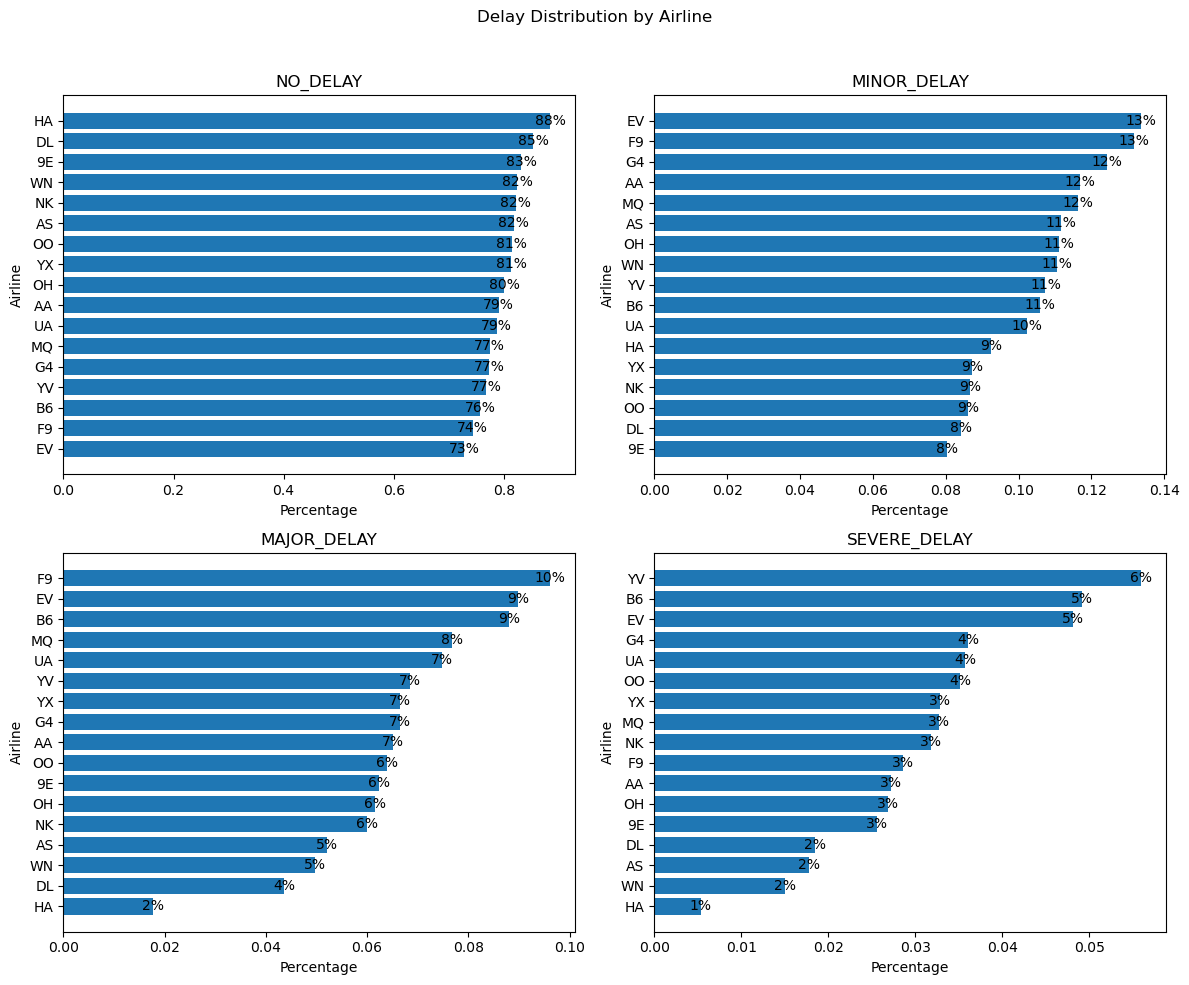

In [17]:
import matplotlib.pyplot as plt

total_flights = df_sampled.groupby('OP_UNIQUE_CARRIER').size()
delay_counts = df_sampled.groupby(['OP_UNIQUE_CARRIER', 'DELAY_CATEGORY']).size().unstack(fill_value=0)
delay_percentages = delay_counts.div(total_flights, axis=0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Delay Distribution by Airline')

delay_categories = ['NO_DELAY', 'MINOR_DELAY', 'MAJOR_DELAY', 'SEVERE_DELAY']
for ax, delay_category in zip(axes.flatten(), delay_categories):
    sorted_data = delay_percentages[delay_category].sort_values()
    ax.barh(sorted_data.index, sorted_data)
    ax.set_title(f'{delay_category}')
    ax.set_ylabel('Airline')
    ax.set_xlabel('Percentage')
    for i, txt in enumerate(sorted_data):
        ax.annotate(f'{txt*100:.0f}%', (sorted_data.iloc[i], sorted_data.index[i]), ha='center', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


From reading these plots, it's apparent that the airlines DL (Delta), HA (Hawaiian), and WN (Southwest) show a higher percentage of on-time flights, whereas budget airlines such as F9 (Frontier), G4 (Allegiant), and B6 (JetBlue) tend to have a higher percentage of delayed flights.

Based on this analysis, it's reasonable to presume that the operating airline plays a role in the possibility of a flight becoming delayed, and should therefore be incorporated as an independent variable in an airline delay prediction model.

### Delays by Departure Hour

Most airlines will schedule their flights to occur during daytime hours. While there are flights (typically referred to as 'red-eye' flights) that occur outside this timeframe, most passengers expect to travel during the waking hours. Early and late-morning delays can cause a chain reaction, resulting in most delays accumulating in the afternoon or evening, with the root cause being late inbound aircraft.

This correlation can be visualized by plotting delay frequency across the hours of the day.

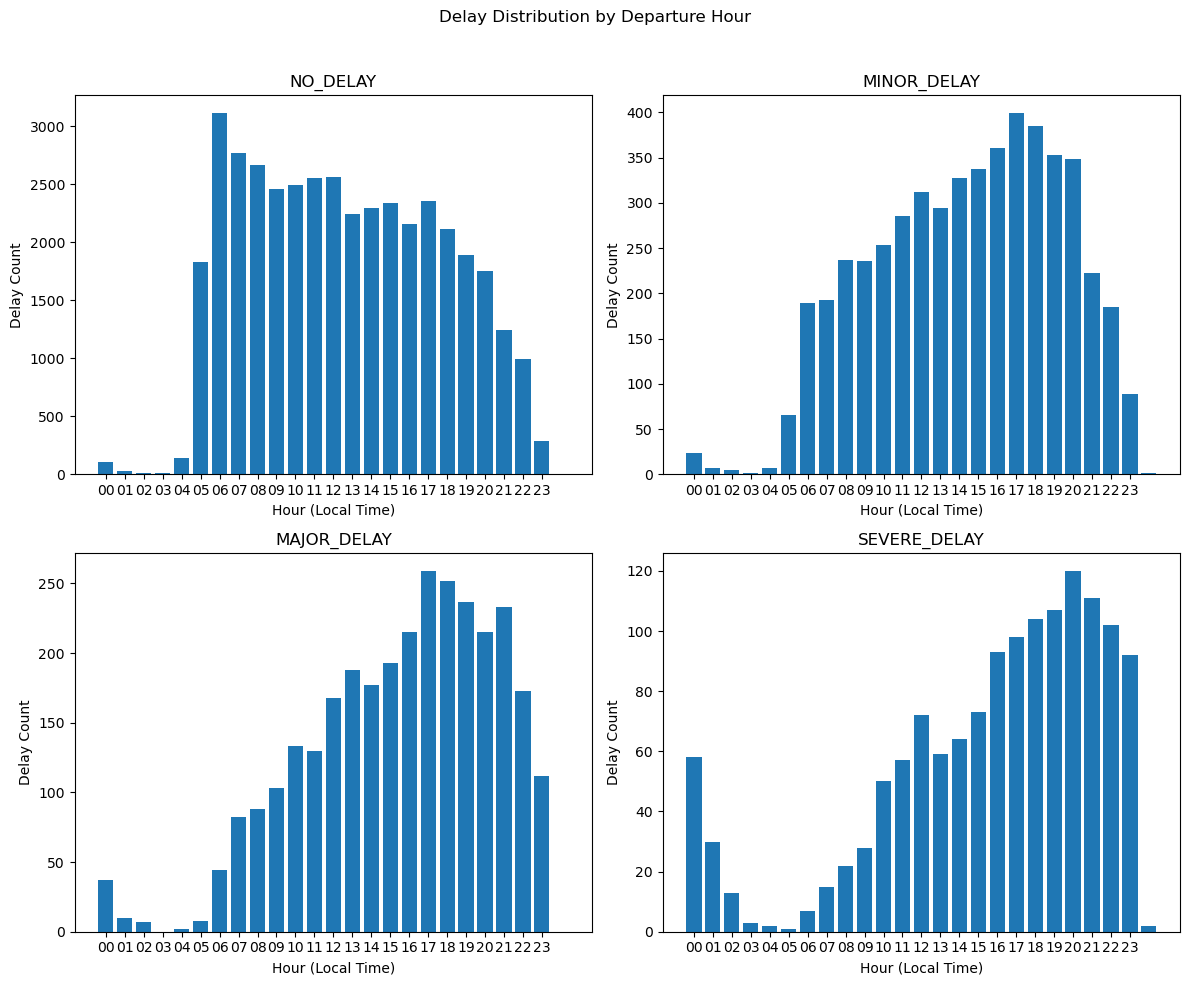

In [19]:
delay_counts = df_sampled.groupby(['DEP_HOUR', 'DELAY_CATEGORY']).size().unstack(fill_value=0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Delay Distribution by Departure Hour')

delay_categories = ['NO_DELAY', 'MINOR_DELAY', 'MAJOR_DELAY', 'SEVERE_DELAY']
for ax, delay_category in zip(axes.flatten(), delay_categories):
    ax.bar(delay_counts.index, delay_counts[delay_category])
    ax.set_title(f'{delay_category}')
    ax.set_xlabel('Hour (Local Time)')
    ax.set_ylabel('Delay Count')
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{i:02}' for i in range(24)])    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The chart representing 'NO_DELAY' clearly shows that most on-time flights depart in the morning, between 6am and 12pm. The remaining charts, each representing the various delay severity categories, clearly shows that late afternoon an evening flights, from about 3pm until 8pm, demonstrate the highest number of total delays.

Based on this trend, it is important that the departure time be included in a predictive model for flight delays.

### Delays by Departure or Arrival City

The airport from which a flight departs might result in a higher chance of a delay if that airport is known for having weather at certain times of the day. The arrival airport might also experience regular weather and ATC delays at certain times as well. ATL (Atlanta) airport is a good example, residing in the southern US where afternoon thunderstorms are frequent and common - and handling the highest amount of air traffic in the world. ATC will often have to route flights around thunderstorms, causing air traffic congestion and ATC "ground stops" - where departing flights are held at the departure airport until air traffic congestion is reduced.

These trends can be expressed by charting the percentage of delayed flights for the airports with the top 15 most delays.

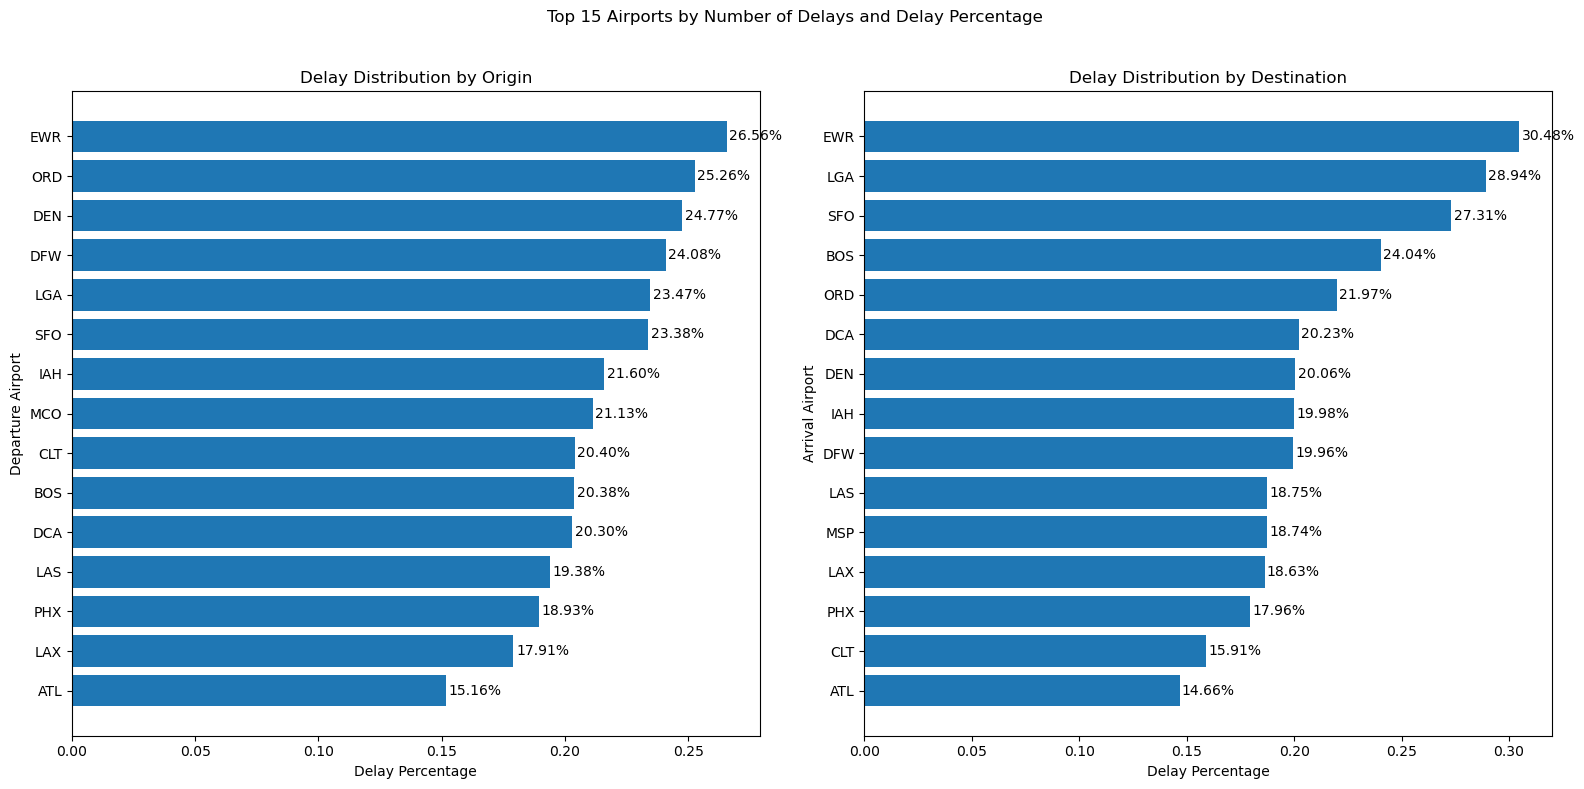

In [28]:
origin_total_flights = df_sampled.groupby('ORIGIN').size()
origin_delay_counts = df_sampled[df_sampled['DELAY_CATEGORY'] != 'NO_DELAY'].groupby('ORIGIN').size()
sorted_origin_delays = origin_delay_counts.sort_values(ascending=False).nlargest(15)
sorted_origin_percentages = sorted_origin_delays.div(origin_total_flights[sorted_origin_delays.index]).sort_values()

dest_total_flights = df_sampled.groupby('DEST').size()
dest_delay_counts = df_sampled[df_sampled['DELAY_CATEGORY'] != 'NO_DELAY'].groupby('DEST').size()
sorted_dest_delays = dest_delay_counts.sort_values(ascending=False).nlargest(15)
sorted_dest_percentages = sorted_dest_delays.div(dest_total_flights[sorted_dest_delays.index]).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Top 15 Airports by Number of Delays and Delay Percentage')

axes[0].barh(sorted_origin_percentages.index, sorted_origin_percentages)
axes[0].set_title('Delay Distribution by Origin')
axes[0].set_xlabel('Delay Percentage')
axes[0].set_ylabel('Departure Airport')
for i, txt in enumerate(sorted_origin_percentages):
    axes[0].annotate(f'{txt*100:.2f}%', (txt + 0.001, i), va='center')

# DEST plot
axes[1].barh(sorted_dest_percentages.index, sorted_dest_percentages)
axes[1].set_title('Delay Distribution by Destination')
axes[1].set_xlabel('Delay Percentage')
axes[1].set_ylabel('Arrival Airport')
for i, txt in enumerate(sorted_dest_percentages):
    axes[1].annotate(f'{txt*100:.2f}%', (txt + 0.001, i), va='center')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From these visualizations (and depending on the overall sample), airports like ORD (Chicago) and DEN (Denver) tend to have up to 25% of their outbound flights delayed, and airports such as EWR (Newark) and LGA (LaGuardia) often have nearly 30% of their inbound flights delayed.

The origin and destination airports both play a factor in the chance of a flight being delayed, and therefore should be included in a predictive model as categorical features.

## Data Preprocessing

To identify which predictive model can provide the best fit for the data, several different models can be assessed with an 80%/20% split on the data for training and testing. Preprocessing will be applied to the data to ensure that non-numeric data is properly transformed into a format the model can understand using a `OneHotEncoder` from the `sklearn` library.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

y = df_sampled['DELAY_CATEGORY']
X = df_sampled.drop(['DELAY_CATEGORY'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['FL_MONTH', 'DEP_HOUR']
categorical_features = ['ORIGIN', 'DEST', 'OP_UNIQUE_CARRIER']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numerical_features), 
        ('cat', categorical_transformer, categorical_features)
    ])